In [ ]:
pip install numpy pandas torch matplotlib seaborn emoji nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

Read the Data in

In [ ]:
synthetic = pd.read_csv('https://github.com/rrandev03/NLP_Final/raw/refs/heads/main/100_data/102_processed/Synthetic_tweets_labelled.csv')

In [ ]:
synthetic.head()

,Tweets,Labels
0,"1. ""EVs convert over 77% of electrical energy ...",Positive
1,"2. ""EV motors have only 20 moving parts vs. 2,...",Positive
2,"3. ""The world’s best-selling EV? The Tesla Mod...",Positive
3,"4. ""Electric cars first appeared in the 1800s,...",Positive
4,"5. ""EVs can run on renewable energy, making th...",Positive


Data Pre Processing

In [ ]:
import re, string
import emoji
import nltk

In [ ]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.replace_emoji(text, replace='')  # Remove emoji by replacing them with an empty string

def strip_numbering(text):
  text = re.sub(r'^\d+\.\s*', '', text)
  return text

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
synthetic = synthetic[:400]
synthetic.tail()

,Tweets,Labels
395,"16. ""Certain EVs require proprietary chargers,...",Negative
396,"17. ""EVs can lose range when parked for extend...",Negative
397,"18. ""High electricity demand in your area migh...",Negative
398,"19. ""Some chargers fail to communicate with ca...",Negative
399,"20. ""Driving electric doesn’t guarantee low em...",Negative


In [ ]:
texts_new = []
for t in synthetic['Tweets']:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(strip_numbering(t)))))))

synthetic['Cleaned_Tweets'] = texts_new
synthetic.head()

,Tweets,Labels,Cleaned_Tweets
0,"1. ""EVs convert over 77% of electrical energy ...",Positive,evs convert over 77 of electrical energy into ...
1,"2. ""EV motors have only 20 moving parts vs. 2,...",Positive,ev motors have only 20 moving parts vs 2000 in...
2,"3. ""The world’s best-selling EV? The Tesla Mod...",Positive,the worlds bestselling ev the tesla model y le...
3,"4. ""Electric cars first appeared in the 1800s,...",Positive,electric cars first appeared in the 1800s but ...
4,"5. ""EVs can run on renewable energy, making th...",Positive,evs can run on renewable energy making them tr...


Importing Transformers

In [ ]:
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel, TFRobertaForSequenceClassification

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

token_lens = []

for txt in synthetic['Cleaned_Tweets'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

MAX TOKENIZED SENTENCE LENGTH: 28


In [ ]:
synthetic = synthetic.sample(frac=1).reset_index(drop=True)

Tweet Label Column Analysis

In [ ]:
synthetic['Labels'].value_counts()


,count
Labels,
Positive,300
Negative,50
Neutral,50


In [ ]:
synthetic['Sentiment'] = synthetic['Labels'].map({'Negative':0,'Neutral':1,'Positive':2})


In [ ]:
synthetic['Sentiment'].value_counts()

,count
Sentiment,
2,300
0,50
1,50


Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(synthetic['Cleaned_Tweets'], synthetic['Sentiment'], test_size=0.2, random_state=42)


In [ ]:
len(X_train)

320

One Hot Encoding

In [ ]:
y_train_spare = y_train.copy()
y_test_spare = y_test.copy()

In [ ]:
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()
y_train= ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
#y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

Roberta Sentiment Analysis

In [ ]:
MAX_LEN=128

def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [ ]:
roberta_sequence_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
import tensorflow as tf

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=10000,
    decay_rate=0.9)

roberta_sequence_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_spare), y=y_train_spare)
class_weights

array([2.60162602, 2.73504274, 0.44444444])

In [ ]:
roberta_history = roberta_sequence_model.fit([train_input_ids, train_attention_masks], y_train, class_weight={i: class_weights[i] for i in range(len(class_weights))}, epochs=20, batch_size=16)

Epoch 1/20
20/20 [==============================] - 45s 376ms/step - loss: 1.0993 - accuracy: 0.3750
Epoch 2/20
20/20 [==============================] - 7s 366ms/step - loss: 0.7253 - accuracy: 0.8031
Epoch 3/20
20/20 [==============================] - 7s 367ms/step - loss: 0.5079 - accuracy: 0.8875
Epoch 4/20
20/20 [==============================] - 7s 371ms/step - loss: 0.4463 - accuracy: 0.9094
Epoch 5/20
20/20 [==============================] - 7s 373ms/step - loss: 0.2651 - accuracy: 0.9531
Epoch 6/20
20/20 [==============================] - 8s 378ms/step - loss: 0.1213 - accuracy: 0.9906
Epoch 7/20
20/20 [==============================] - 8s 381ms/step - loss: 0.2651 - accuracy: 0.9531
Epoch 8/20
20/20 [==============================] - 8s 386ms/step - loss: 0.1031 - accuracy: 0.9875
Epoch 9/20
20/20 [==============================] - 8s 390ms/step - loss: 0.0818 - accuracy: 0.9719
Epoch 10/20
20/20 [==============================] - 8s 392ms/step - loss: 0.0247 - accuracy: 0.993

Save Model

Test data

In [ ]:
logits = roberta_sequence_model.predict([test_input_ids, test_attention_masks]).logits

3/3 [==============================] - 3s 196ms/step


In [ ]:
probabilities = tf.nn.softmax(logits, axis=-1).numpy()
y_pred = np.zeros_like(probabilities)
y_pred[np.arange(len(y_pred)), probabilities.argmax(1)] = 1

              precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.62      0.45      0.53        11
           2       0.94      1.00      0.97        60

    accuracy                           0.88        80
   macro avg       0.73      0.67      0.69        80
weighted avg       0.86      0.88      0.86        80



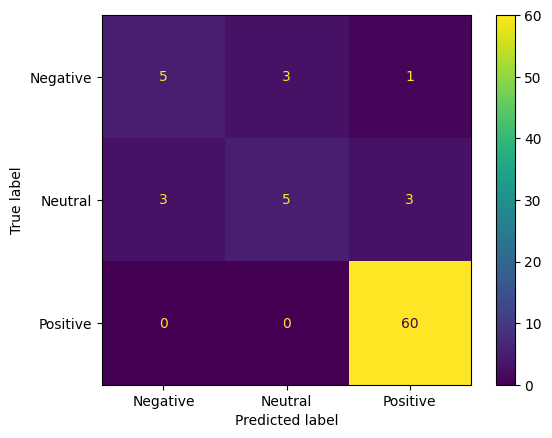

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay

print(classification_report(y_test.argmax(1), y_pred.argmax(1)))
cm  = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()
plt.show()

In [ ]:
y_test_spare.value_counts()

,count
Sentiment,
2,60
1,11
0,9


In [ ]:
y_train_spare.value_counts()

,count
Sentiment,
2,240
0,41
1,39


In [ ]:
actual = pd.DataFrame({"Actual label": y_test.argmax(1)})

In [ ]:
predicted = pd.DataFrame({"Predicted label": y_pred.argmax(1)})

In [ ]:
full_results = pd.concat([X_test, actual, predicted], axis = 1)

In [ ]:
full_results.loc[(full_results['Actual label'] == 1)& (full_results['Predicted label'] == 2)]

,Cleaned_Tweets,Actual label,Predicted label
34,ev range estimates are just thatestimates real...,1,2
67,higher insurance costs for evs can offset savi...,1,2
77,range anxiety is a common feeling for new ev o...,1,2
